# Text Experiments
---
[Alejandro Ciuba](https://alejandrociuba.github.io), alejandrociuba@pitt.edu
---
## Summary

Experiments for the text-only sentiment analysis models. We are trying the following models:
- [SVC](#svc)
- [Logistic Regression with Random Search](#logistic-regression-with-random-search)
- [Naive Bayes](#naive-bayes)
    - [Multinomial](#multinomial-nb)
    - [Complement](#complement-nb)
- [One vs. Rest](#one-vs-rest)
- [FFNN](#ffnn)
- [LSTM](#lstm)

For SVC, Logistic Regression, both Naive Bayes and FFNN (which will only accept string inputs and outputs) we will experiment with the following:
- Count Vectors
- TF-IDF Vectors
- Gensim Custom Doc2Vec Vectors

For LSTM
- Gensim word2vec Vectors via [GoogleNews](https://code.google.com/archive/p/word2vec/)
---
## Setup
### Necessary Imports
#### Experiment Class & Metrics

In [120]:
from experiment import (Experiment,
                        plot_confusion_matrix,
                        vectorizer, )

from sklearn.metrics import (accuracy_score,
                             precision_recall_fscore_support,
                             confusion_matrix, )

#### Models

In [121]:
from neural import (FFNN,
                    LSTM, )
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import (MultinomialNB,
                                 ComplementNB, )
from sklearn.svm import SVC

from torch.nn import (Linear,
                      Softmax,
                      Tanh,
                      ReLU,
                      LeakyReLU, )

#### Other

In [122]:
from collections import OrderedDict
from gensim.models.doc2vec import Doc2Vec
from gensim.models import KeyedVectors
from gensim.utils import simple_preprocess
from nltk import word_tokenize
from nltk.corpus import stopwords
from scipy.stats import (uniform,
                         ttest_ind_from_stats, )
from sklearn.feature_extraction.text import (CountVectorizer,
                                             TfidfVectorizer, )
from sklearn.model_selection import RandomizedSearchCV
from torch.utils.data import WeightedRandomSampler

import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


### Global Variables & Settings

In [123]:
# Turn this off
%pprint
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

Pretty printing has been turned ON


In [124]:
DATA_PATH = "../data/final-splits.csv"
DATA = pd.read_csv(DATA_PATH, index_col=False)
EMOTIONS = DATA.emotion.unique()

SEED = 42

METRICS = {"accuracy": (accuracy_score, {}),
           "precision_recall_fscore_support": (precision_recall_fscore_support, {"average": "macro", "zero_division": np.nan}),
           "confusion_matrix": (confusion_matrix, {"labels": EMOTIONS}), }

RESULTS = {"experiment": [],
           "accuracy": [],
           "precision": [],
           "recall": [],
           "fpr": [],
           "f1_score": [], 
           "comments": [], }

WTESTS = False  # Include and load word2vec experiments
DTESTS = True   # Include and load doc2vec experiments

# Only run the experiments listed here; empty means run all
targets = []
def selected(target):
    if target in targets or len(targets) == 0:
        if ("D2V" in target and not DTESTS) or ("W2V" in target and not WTESTS):
            return False
        return True
    return False

In [125]:
if WTESTS:

    WORD2VEC_PATH = "../data/word2vec/GoogleNews-vectors-negative300.bin"
    W2V: KeyedVectors = KeyedVectors.load_word2vec_format(WORD2VEC_PATH, binary=True)

if DTESTS:

    DOC2VEC_PATH = "../data/doc2vec-15-70.bin"
    D2V: Doc2Vec = Doc2Vec.load(DOC2VEC_PATH)

STOPWORDS = stopwords.words()

### Functions

In [126]:
def display_results(metrics, experiment, comments):

    print(f"Accuracy: {metrics['accuracy']:.3f}")
    
    prec, recall, f1, _ = metrics['precision_recall_fscore_support']

    print(f"Precision: {prec:.3f}")
    print(f"Recall: {recall:.3f}")

    conf: np.ndarray = metrics['confusion_matrix']

    def calc_fpr(i: int):

        tp = conf[i, i]
        fp = conf[:, i].sum() - tp
        fn = conf[i, :].sum() - tp
        tn = conf.sum() - fp - fn - tp

        return fp / (fp + tn)

    fpr = sum([calc_fpr(i) for i in range(len(EMOTIONS))]) / len(EMOTIONS)

    print(f"FPR: {fpr:.3f}")
    print(f"F1-Score: {f1:.3f}")

    plot_confusion_matrix(conf, labels=EMOTIONS)

    RESULTS['experiment'].append(experiment)
    RESULTS['accuracy'].append(metrics['accuracy'])
    RESULTS['precision'].append(prec)
    RESULTS['recall'].append(recall)
    RESULTS['fpr'].append(fpr)
    RESULTS['f1_score'].append(f1)
    RESULTS['comments'].append(comments)

In [127]:
def exp_run(name, model, transforms, list_kwargs = None, comments = "", **kwargs):

    exp = Experiment(name=name, data=DATA, model=model, comments=comments)

    if transforms:
        for i, transform in enumerate(transforms):
            exp.transform(transform, **(list_kwargs[i] if list_kwargs else {}))

    results = exp.full_run(metrics=METRICS, **kwargs)
    display_results(results, name, comments)

    return exp

In [128]:
MAX_FEATS = 5_000
def default_vector(name: str, max_features: int=MAX_FEATS):

    if name == "count":
        return CountVectorizer(stop_words="english", max_features=max_features)
    elif name == "tfidf":
        return TfidfVectorizer(stop_words="english", max_features=max_features) 

In [129]:
def w2v_transform(X, y, subset):
    return [[W2V[word] for word in simple_preprocess(sent) if word in W2V.key_to_index.keys()] for sent in X], y

In [130]:
def d2v_transform(X, y, subset):
    return [D2V.infer_vector(simple_preprocess(sent)) for sent in X], y

In [131]:
CAT_TO_ID = {cat: i for i, cat in enumerate(DATA["emotion"].unique())}
ID_TO_CAT = {CAT_TO_ID[cat]: cat for cat in CAT_TO_ID}

def cat_transform(X, y, subset):
    return X, np.array([CAT_TO_ID[cat] for cat in y], dtype=int)

***
## SVC

Accuracy: 0.560
Precision: 0.603
Recall: 0.512
FPR: 0.076
F1-Score: 0.523


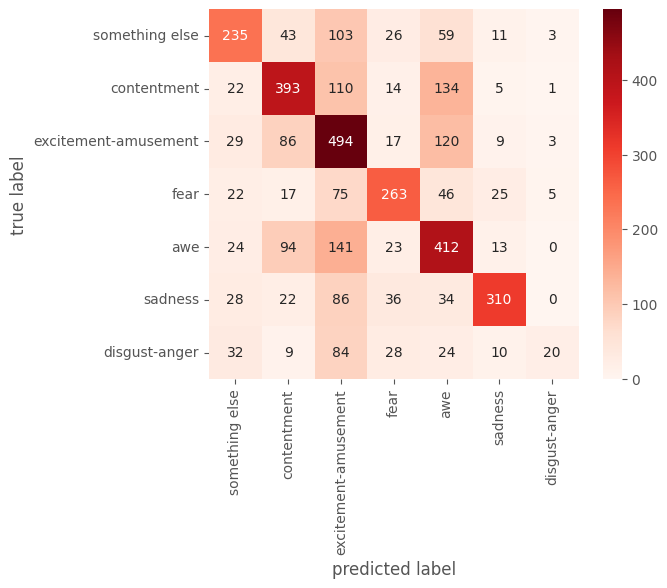

In [132]:
EXP1A = "SVC/COUNT"

if selected(EXP1A):
    exp_run(EXP1A, model=SVC(C=1), transforms=[vectorizer], list_kwargs=[{"vect": default_vector("count")}])

Accuracy: 0.579
Precision: 0.627
Recall: 0.542
FPR: 0.073
F1-Score: 0.558


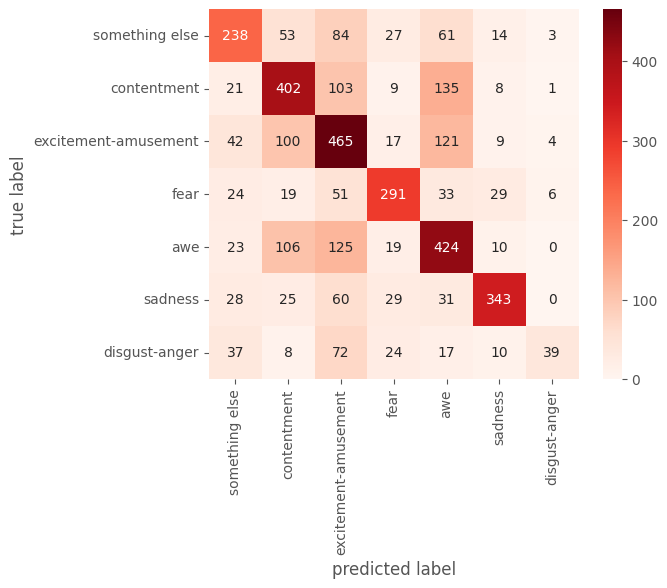

In [133]:
EXP1B = "SVC/TFIDF"

if selected(EXP1B):
    exp_run(EXP1B, model=SVC(C=1), transforms=[vectorizer], list_kwargs=[{"vect": default_vector("tfidf")}])

Accuracy: 0.409
Precision: 0.403
Recall: 0.366
FPR: 0.102
F1-Score: 0.363


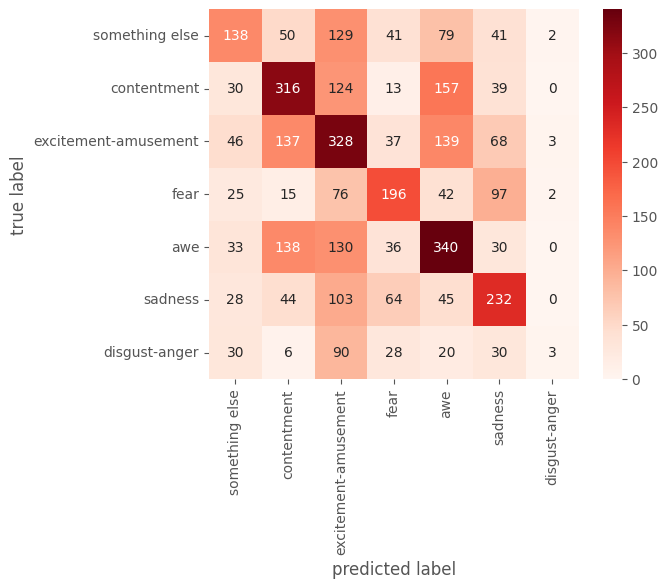

In [134]:
EXP1C = "SVC/D2V"

if selected(EXP1C):
    exp_run(EXP1C, model=SVC(C=1), transforms=[d2v_transform])

***
## Logistic Regression with Random Search

/home/computer_cat/miniconda3/envs/deep_learning/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/computer_cat/miniconda3/envs/deep_learning/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/computer_cat/miniconda3/envs/deep_learning/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/computer_cat/miniconda3/envs/deep_learning/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/computer_cat/miniconda3/envs/deep_learning/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_

Accuracy: 0.592
Precision: 0.605
Recall: 0.565
FPR: 0.070
F1-Score: 0.576


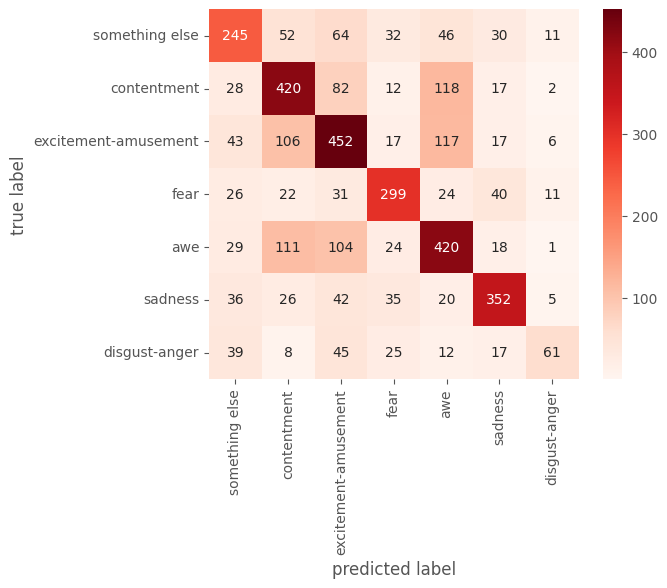

{'C': 0.3998609717152555, 'l1_ratio': 0.04666566321361543, 'penalty': 'elasticnet'}


In [135]:
EXP2A = "LOG/COUNT"

if selected(EXP2A):

    distribution = {"C": uniform(),
                    "penalty": ["l1", "l2", "elasticnet"],
                    "l1_ratio": uniform(), }

    model = RandomizedSearchCV(estimator=LogisticRegression(solver="saga"), param_distributions=distribution, n_jobs=4, random_state=SEED)

    exp = exp_run(EXP2A, model=model, transforms=[vectorizer], list_kwargs=[{"vect": default_vector("count")}])
    print(exp.model.best_params_)

/home/computer_cat/miniconda3/envs/deep_learning/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/computer_cat/miniconda3/envs/deep_learning/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/computer_cat/miniconda3/envs/deep_learning/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/computer_cat/miniconda3/envs/deep_learning/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/computer_cat/miniconda3/envs/deep_learning/lib/python3.11/site-packages/sklearn/linear

Accuracy: 0.589
Precision: 0.620
Recall: 0.555
FPR: 0.071
F1-Score: 0.568


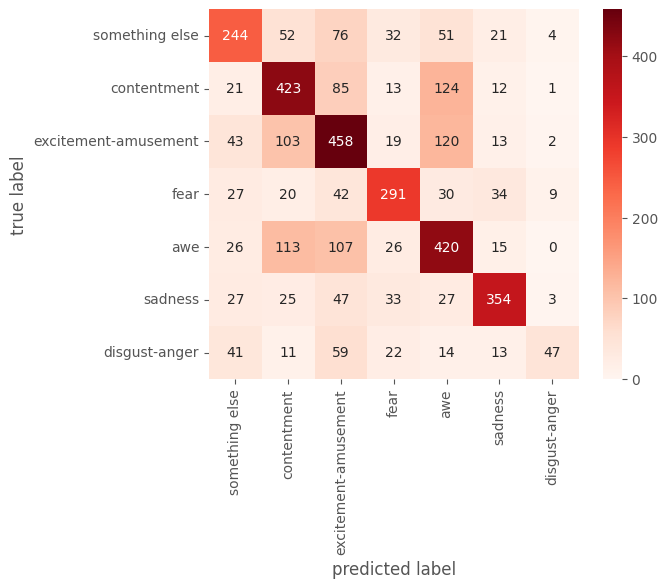

{'C': 0.7796910002727693, 'l1_ratio': 0.596850157946487, 'penalty': 'l2'}


In [136]:
EXP2B = "LOG/TFIDF"

if selected(EXP2B):

    distribution = {"C": uniform(),
                    "penalty": ["l1", "l2", "elasticnet"],
                    "l1_ratio": uniform(), }
    
    model = RandomizedSearchCV(estimator=LogisticRegression(solver="saga"), param_distributions=distribution, n_jobs=4, random_state=SEED)

    exp = exp_run(EXP2B, model=model, transforms=[vectorizer], list_kwargs=[{"vect": default_vector("tfidf")}])
    print(exp.model.best_params_)

/home/computer_cat/miniconda3/envs/deep_learning/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/computer_cat/miniconda3/envs/deep_learning/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/computer_cat/miniconda3/envs/deep_learning/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/computer_cat/miniconda3/envs/deep_learning/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/computer_cat/miniconda3/envs/deep_learning/lib/python3.11/site-packages/sklearn/linear

Accuracy: 0.406
Precision: 0.432
Recall: 0.370
FPR: 0.102
F1-Score: 0.367


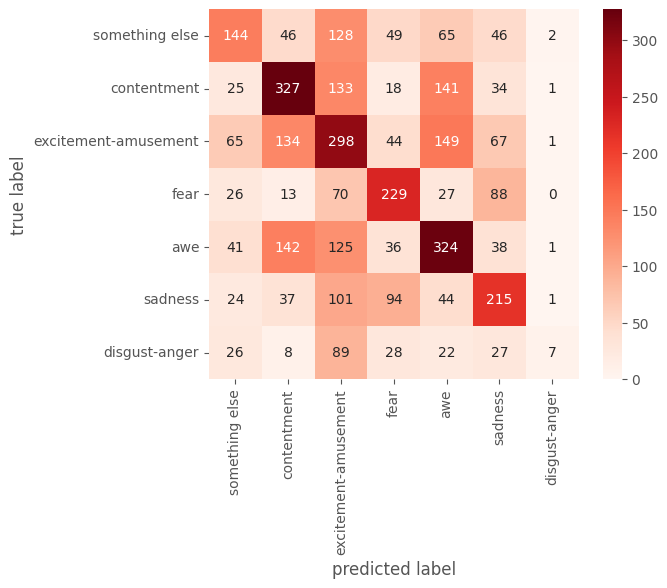

{'C': 0.6011150117432088, 'l1_ratio': 0.7080725777960455, 'penalty': 'l2'}


In [137]:
EXP2C = "LOG/D2V"

if selected(EXP2C):

    distribution = {"C": uniform(),
                    "penalty": ["l1", "l2", "elasticnet"],
                    "l1_ratio": uniform(), }
    
    model = RandomizedSearchCV(estimator=LogisticRegression(solver="saga"), param_distributions=distribution, n_jobs=4, random_state=SEED)

    exp = exp_run(EXP2C, model=model, transforms=[d2v_transform])
    print(exp.model.best_params_)

***
## Naive Bayes
### Multinomial NB

Accuracy: 0.597
Precision: 0.609
Recall: 0.565
FPR: 0.069
F1-Score: 0.569


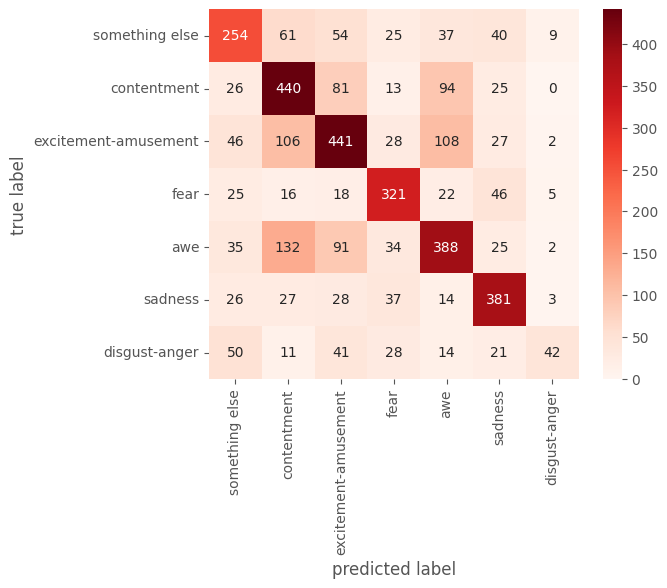

In [138]:
EXP3A = "MNB/COUNT"

if selected(EXP3A):
    exp_run(EXP3A, model=MultinomialNB(), transforms=[vectorizer], list_kwargs=[{"vect": default_vector("count")}])

Accuracy: 0.574
Precision: 0.662
Recall: 0.518
FPR: 0.074
F1-Score: 0.517


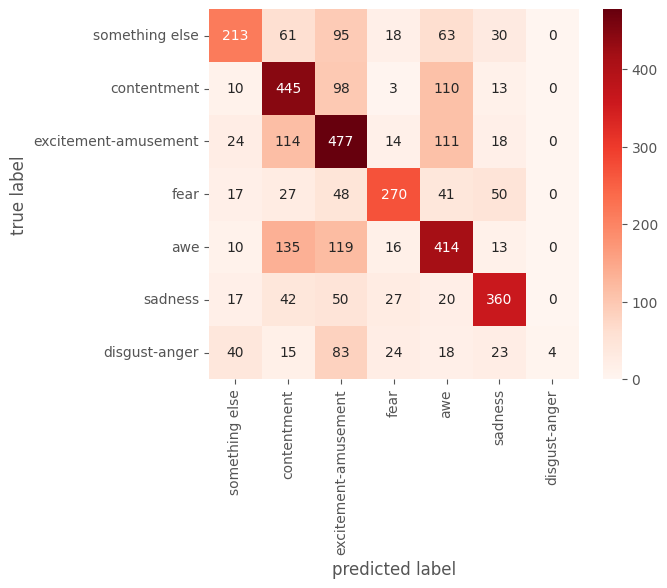

In [139]:
EXP3B = "MNB/TFIDF"

if selected(EXP3B):
    exp_run(EXP3B, model=MultinomialNB(), transforms=[vectorizer], list_kwargs=[{"vect": default_vector("tfidf")}])

### Complement NB

Accuracy: 0.608
Precision: 0.604
Recall: 0.587
FPR: 0.067
F1-Score: 0.588


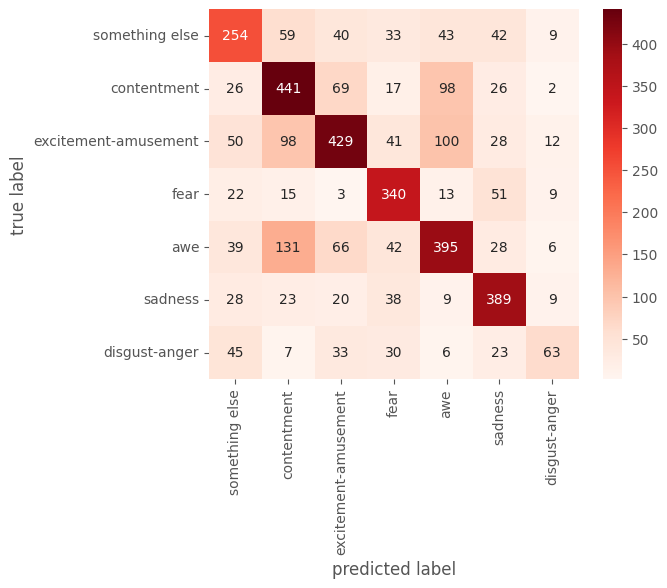

In [140]:
EXP4A = "COM/COUNT"

if selected(EXP4A):
    exp_run(EXP4A, model=ComplementNB(), transforms=[vectorizer], list_kwargs=[{"vect": default_vector("count")}])

Accuracy: 0.602
Precision: 0.597
Recall: 0.583
FPR: 0.068
F1-Score: 0.583


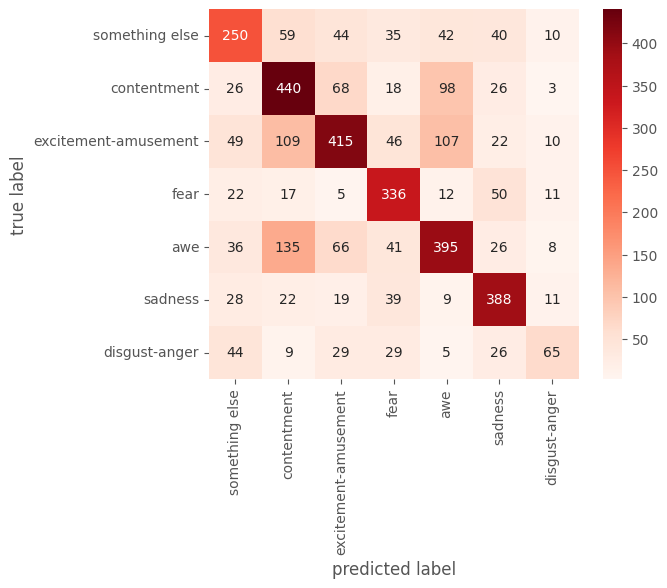

In [141]:
EXP4B = "COM/TFIDF"

if selected(EXP4B):
    exp_run(EXP4B, model=ComplementNB(), transforms=[vectorizer], list_kwargs=[{"vect": default_vector("tfidf")}])

***
## One Vs. Rest

For this, we will only run the best of the non-NN models.

Accuracy: 0.607
Precision: 0.624
Recall: 0.575
FPR: 0.067
F1-Score: 0.578


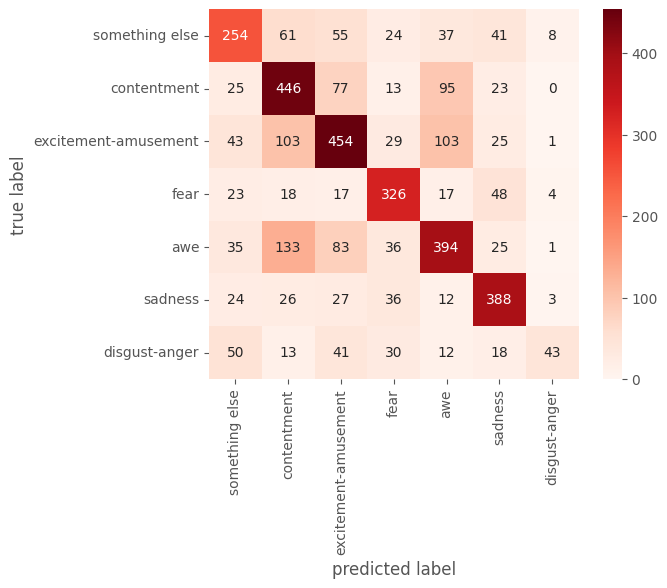

In [152]:
EXP5A = "ONE"

if selected(EXP5A):
    exp_run(EXP5A, model=OneVsRestClassifier(MultinomialNB()), transforms=[vectorizer], list_kwargs=[{"vect": default_vector("count")}])

***
## FFNN

In [143]:
def plot_loss(loss_record):

    df = pd.DataFrame(loss_record)
    df['training'] = df['epoch'] + df['step']
    sns.lineplot(data=df, x='training', y='loss')

In [144]:
weights = list(range(len(DATA.emotion.unique())))
for k in CAT_TO_ID:
    weights[CAT_TO_ID[k]] = 1 / DATA.emotion.value_counts()[k]

weights

[0.00041631973355537054,
 0.00029481132075471697,
 0.0002637826431020839,
 0.0004415011037527594,
 0.0002828054298642534,
 0.00038774718883288094,
 0.000966183574879227]

Accuracy: 0.180
Precision: 0.129
Recall: 0.141
FPR: 0.143
F1-Score: 0.123


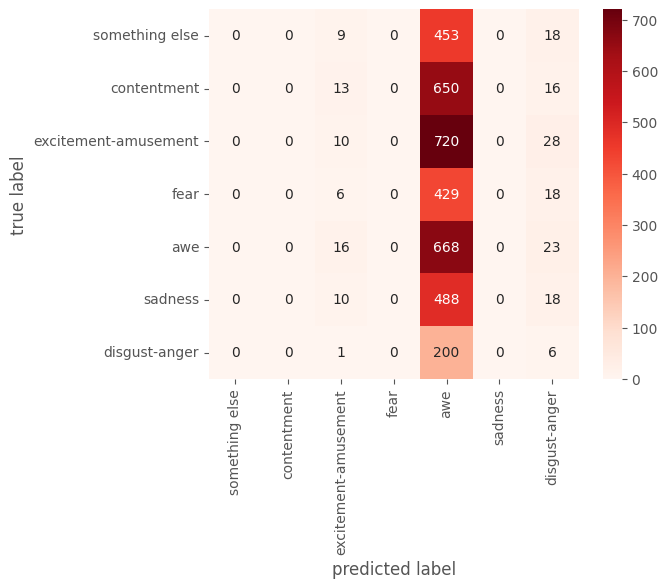

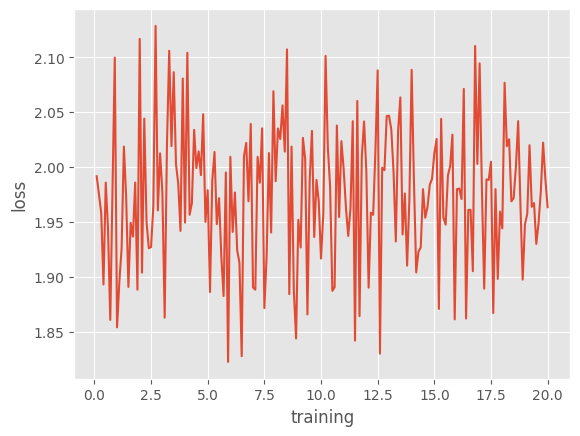

In [145]:
EXP6A = "FFNN/D2V"

if selected(EXP6A):

    def to_emotions(y_true, y_pred):
        return [ID_TO_CAT[i] for i in y_true], [ID_TO_CAT[i] for i in y_pred]

    numpy_transform = lambda X, y, subset: (np.array(X), y)

    steps = OrderedDict([("l1", Linear(15, 10)),
                         ("a1", Softmax()),
                         ("l2", Linear(10, 7)), ])

    config = {"steps": steps,
              "lr": 1E-100,
              "epochs": 20,
              "batch_size": 16,
              "binary": False, }

    exp = exp_run(EXP6A, model=FFNN(**config), transforms=[d2v_transform, cat_transform, numpy_transform], verbose=False, post=to_emotions)
    plot_loss(exp.model.loss_record)

Accuracy: 0.179
Precision: 0.109
Recall: 0.147
FPR: 0.142
F1-Score: 0.129


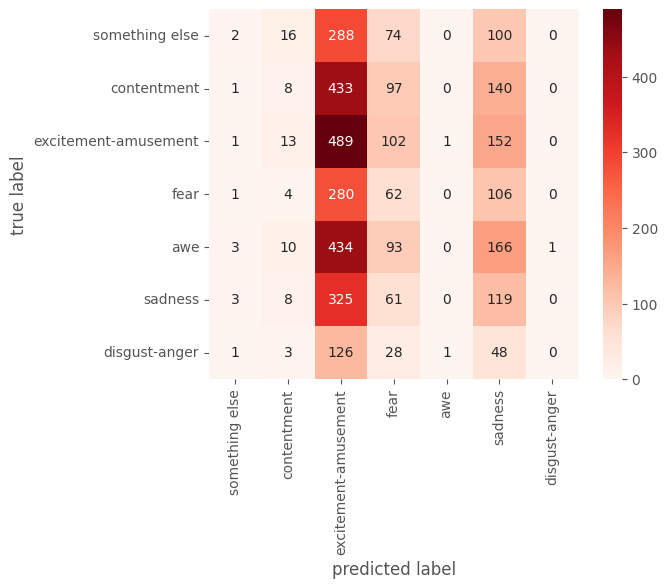

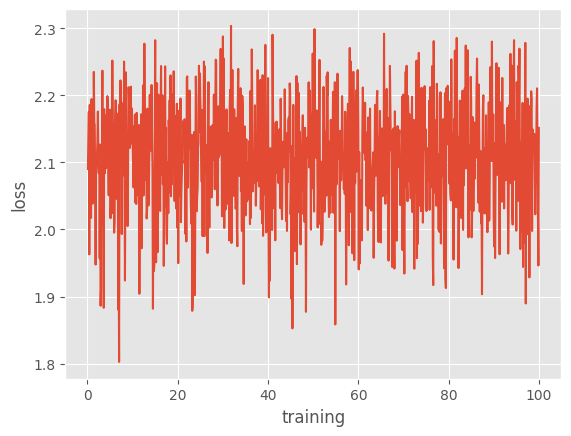

In [146]:
EXP6B = "FFNN/D2VO"

if selected(EXP6B):

    def to_emotions(y_true, y_pred):
        return [ID_TO_CAT[i] for i in y_true], [ID_TO_CAT[i] for i in y_pred]

    numpy_transform = lambda X, y, subset: (np.array(X), y)

    steps = OrderedDict([("l1", Linear(15, 10)),
                         ("a1", Tanh()),
                         ("l2", Linear(10, 7)), ])

    sampler = WeightedRandomSampler(weights,
                                    len(DATA[DATA['split'] == "TRAIN"]),
                                    replacement=True)

    config = {"steps": steps,
              "lr": 1E-10,
              "epochs": 100,
              "batch_size": 16,
              "binary": False, 
              "sampler": sampler, }

    exp = exp_run(EXP6B, model=FFNN(**config), transforms=[d2v_transform, cat_transform, numpy_transform], verbose=False, post=to_emotions)
    plot_loss(exp.model.loss_record)

Accuracy: 0.075
Precision: 0.093
Recall: 0.151
FPR: 0.142
F1-Score: 0.141


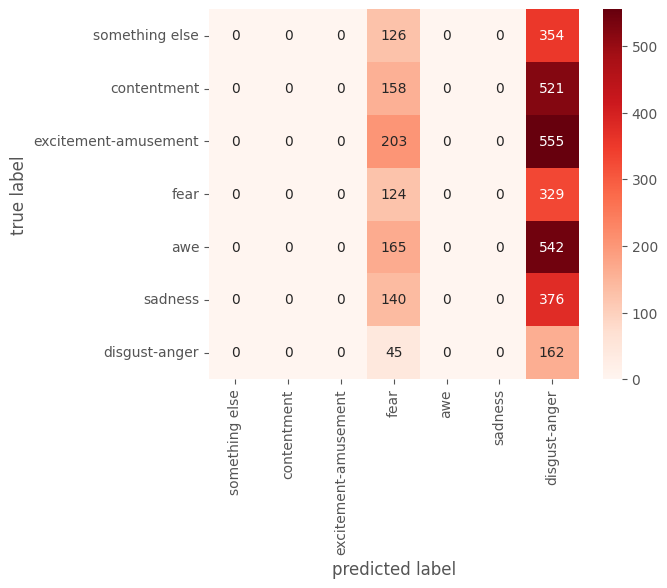

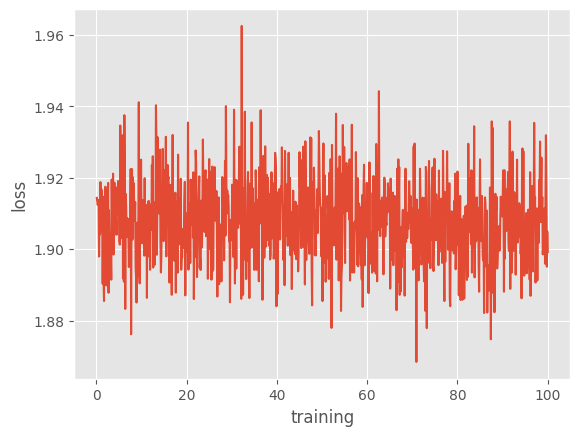

In [147]:
EXP6C = "FFNN/TFIDFO"

if selected(EXP6C):

    def to_emotions(y_true, y_pred):
        return [ID_TO_CAT[i] for i in y_true], [ID_TO_CAT[i] for i in y_pred]

    numpy_transform = lambda X, y, subset: (X.toarray().astype(np.float32), y)

    steps = OrderedDict([("l1", Linear(MAX_FEATS, 150)),
                         ("a1", Tanh()),
                         ("l2", Linear(150, 50)),
                         ("a2", Tanh()),
                         ("l3", Linear(50, 7)), ])

    sampler = WeightedRandomSampler(weights,
                                    len(DATA[DATA['split'] == "TRAIN"]),
                                    replacement=True)

    config = {"steps": steps,
              "lr": 1E-10,
              "epochs": 100,
              "batch_size": 16,
              "binary": False, 
              "sampler": sampler, }

    exp = exp_run(EXP6C, model=FFNN(**config), transforms=[vectorizer, cat_transform, numpy_transform], list_kwargs=[{"vect": default_vector("tfidf")}, {}, {}], verbose=False, post=to_emotions)
    plot_loss(exp.model.loss_record)

***
## Results

In [148]:
results_df = pd.DataFrame(RESULTS)
results_df["ratio"] = results_df["recall"] / results_df["fpr"]
results_df

,experiment,accuracy,precision,recall,fpr,f1_score,comments,ratio
0,SVC/COUNT,0.559737,0.602986,0.511543,0.076349,0.523303,,6.700061
1,SVC/TFIDF,0.579474,0.626646,0.542368,0.072766,0.558123,,7.453587
2,SVC/D2V,0.408684,0.402630,0.366184,0.101888,0.362735,,3.593997
3,LOG/COUNT,0.591842,0.605474,0.565177,0.070039,0.576112,,8.069471
4,LOG/TFIDF,0.588684,0.619885,0.555010,0.070874,0.568134,,7.830965
5,LOG/D2V,0.406316,0.431988,0.369858,0.102100,0.367007,,3.622503
6,MNB/COUNT,0.596579,0.609162,0.565379,0.069037,0.568693,,8.189539
7,MNB/TFIDF,0.574474,0.662048,0.518144,0.073778,0.516840,,7.022999
8,COM/COUNT,0.608158,0.603706,0.587441,0.066612,0.587626,,8.818847
9,COM/TFIDF,0.602368,0.597031,0.583244,0.067595,0.583208,,8.628523


In [149]:
DATA['emotion'].value_counts().describe()

count       7.000000
mean     2714.285714
std       951.446918
min      1035.000000
25%      2333.500000
50%      2579.000000
75%      3464.000000
max      3791.000000
Name: count, dtype: float64

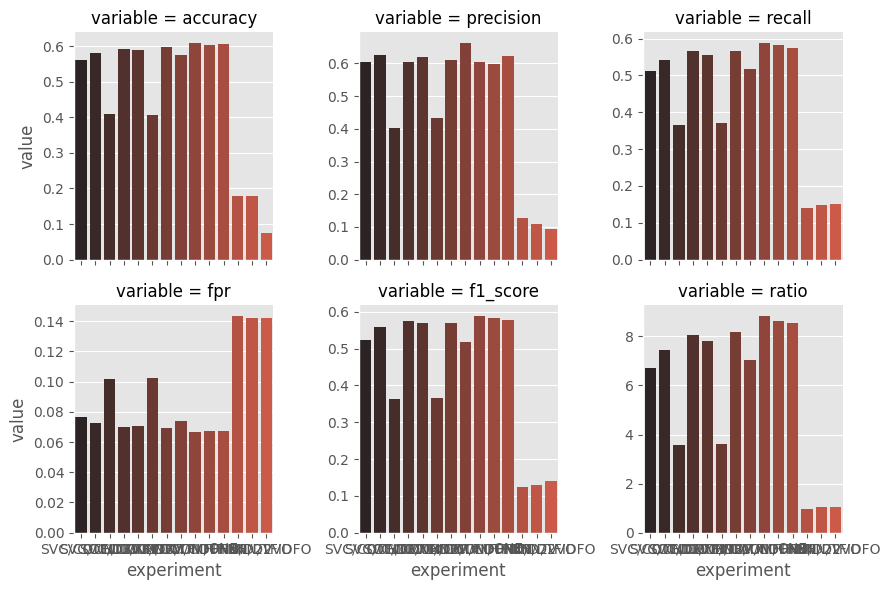

In [150]:
grid = sns.FacetGrid(data=results_df.drop(columns=["comments"]).melt(id_vars=["experiment"]),
                     col="variable", col_wrap=3, sharey=False)
grid.map_dataframe(sns.barplot, x="experiment", y="value", hue="experiment")
